In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [4]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [5]:
train_data.shape,test_data.shape

((210,), (60,))

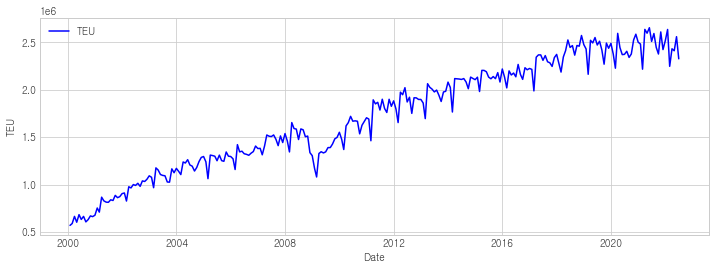

In [6]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='TEU')
plt.legend()

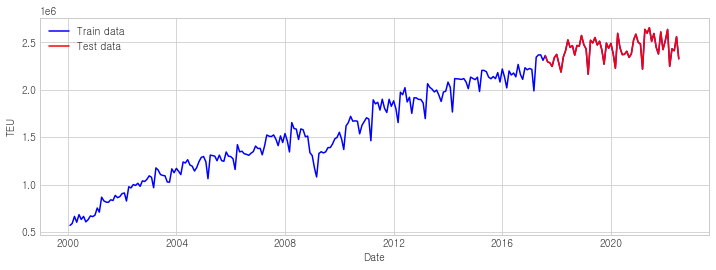

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [8]:
seasonal = pd.read_csv('계절성예측.csv')

In [9]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -80
train = raw_df[0:split] 
test = raw_df[split:] 

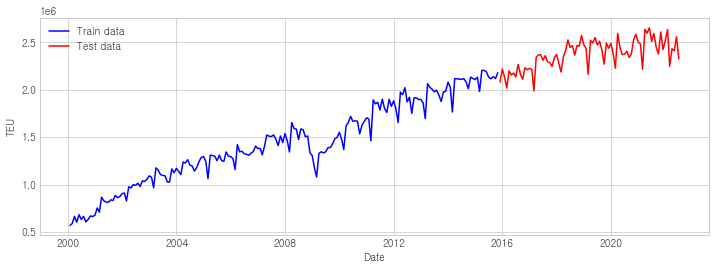

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [17]:
len(train),len(test)

(190, 80)

In [18]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
window_size = 20 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 60   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [22]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_train.shape,Y_train.shape

((111, 20, 10), (111, 60, 1))

### 2. X_test,Y_test 배열

In [24]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [25]:
X_test.shape,Y_test.shape

((1, 20, 10), (1, 60, 1))

In [26]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [27]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(Conv1D(filters=48, kernel_size=2,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),padding='causal'))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(Flatten())

model.add(RepeatVector(60)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(66, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
11/11 [==============================] - 6s 418ms/step - loss: 0.4460 - mae: 0.5839 - val_loss: 0.4504 - val_mae: 0.6140
Epoch 2/200
11/11 [==============================] - 0s 40ms/step - loss: 0.2692 - mae: 0.4401 - val_loss: 0.3243 - val_mae: 0.4942
Epoch 3/200
11/11 [==============================] - 0s 34ms/step - loss: 0.1438 - mae: 0.3038 - val_loss: 0.1588 - val_mae: 0.3254
Epoch 4/200
11/11 [==============================] - 0s 35ms/step - loss: 0.1024 - mae: 0.2578 - val_loss: 0.1583 - val_mae: 0.3406
Epoch 5/200
11/11 [==============================] - 0s 35ms/step - loss: 0.0821 - mae: 0.2284 - val_loss: 0.1284 - val_mae: 0.3003
Epoch 6/200
11/11 [==============================] - 0s 30ms/step - loss: 0.0659 - mae: 0.2056 - val_loss: 0.1255 - val_mae: 0.3081
Epoch 7/200
11/11 [==============================] - 0s 32ms/step - loss: 0.0605 - mae: 0.1948 - val_loss: 0.1527 - val_mae: 0.3413
Epoch 8/200
11/11 [==============================] - 0s 33ms/step - loss: 0

In [28]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

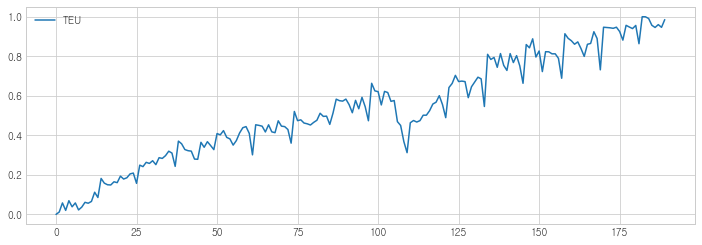

In [29]:
label_train.plot()

<AxesSubplot:>

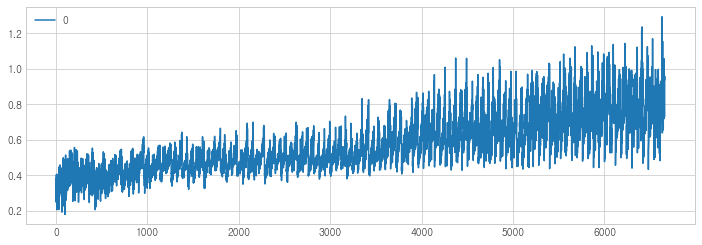

In [30]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### 2017.07 ~ 2022.06

In [31]:
X_test_1 = np.array(feature_test.head(20)).reshape((1,20, 10)) 

In [32]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [33]:
dfs = [] # List 
for i in range(30): 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

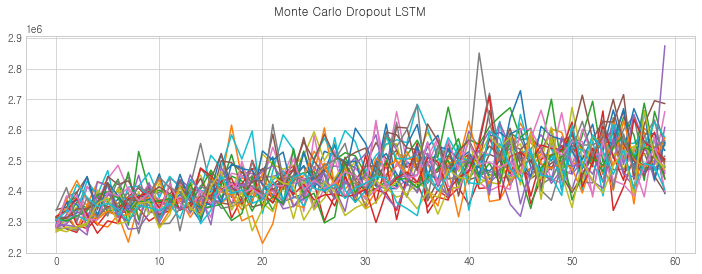

In [34]:
rcParams['figure.figsize'] = 12, 4
plt.suptitle('Monte Carlo Dropout LSTM')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [35]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [36]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [37]:
#df.to_csv('60개월1.csv')

### 계절변동과의 비교(예측 시나리오 선정 사전 단계)

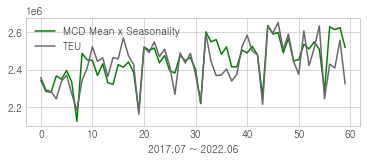

In [39]:
plt.figure(figsize=(6,2))
plt.plot(df.transpose().mean()*seasonal.reset_index()['Seasonal'],color='green',label='MCD Mean x Seasonality')
plt.plot(test_data.reset_index()['TEU'],color='dimgrey',label='TEU')
plt.xlabel('2017.07 ~ 2022.06')
plt.legend(loc=2)

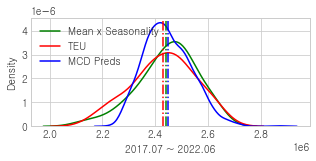

In [42]:
plt.figure(figsize=(5,2))
sns.distplot(df.transpose().mean()*seasonal.reset_index()['Seasonal'],hist=False,color='green',label='Mean x Seasonality')
sns.distplot(test_data,hist=False,color='red',label='TEU')
sns.distplot(df,hist=False,color='blue',label='MCD Preds')
plt.axvline(2445994.226855085,color='blue',linestyle='dashdot')
plt.axvline(2440384.4607475973,color='green',linestyle='dashdot')
plt.axvline(test_data.mean(),color='red',linestyle='dashdot')
plt.xlabel('2017.07 ~ 2022.06')
plt.legend(loc=2)

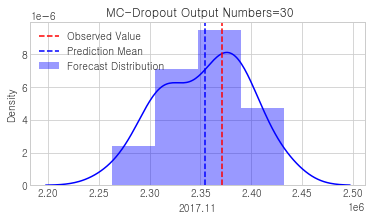

In [37]:
plt.figure(figsize=(6,3))
plt.title(' MC-Dropout Output Numbers=30')
sns.distplot(df.transpose()[4],color='blue',label='Forecast Distribution')
plt.axvline(x=test_data.reset_index()['TEU'][5], color='red',linestyle='dashed',label='Observed Value')
plt.axvline(x=df.transpose()[4].mean(), color='blue',linestyle='dashed',label='Prediction Mean')
#sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU')
plt.xlabel('2017.11')
plt.legend() # 예측 예시

In [38]:
np.mean(df.std()/df.mean()) # 예측값 변동계수

0.03541135415434837

### 추세 대비 정확도

In [39]:
rmse = math.sqrt(mean_squared_error(trend.reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.reset_index()['TEU_Trend']- df.transpose().mean())/ trend.reset_index()['TEU_Trend'])*100) )

RMSE: 32263.32100113968
MAPE: 1.098111640298281


In [40]:
rmse = math.sqrt(mean_squared_error(trend.reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.reset_index()['TEU_Trend']- df.transpose().median())/ trend.reset_index()['TEU_Trend'])*100) )

RMSE: 32981.30589010129
MAPE: 1.1184783227022939


### 전체 인덱스 

In [41]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2317808.0,2304661.0,2281540.75,2308442.25,2280462.25,2294563.25,2266646.5,2286689.25,2272825.5,2313815.25,2289457.25,2313639.75,2311252.25,2302279.5,2288623.0,2340109.0,2312329.0,2280879.75,2267522.5,2307652.75,2306174.0,2307074.25,2315464.0,2318264.0,2285360.25,2314336.5,2283466.0,2336985.25,2276552.25,2306825.5


In [42]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


### Epistemic Uncertainty

Mean RMSE: 111060.21707607732
Mean MAPE: 3.705538132705557


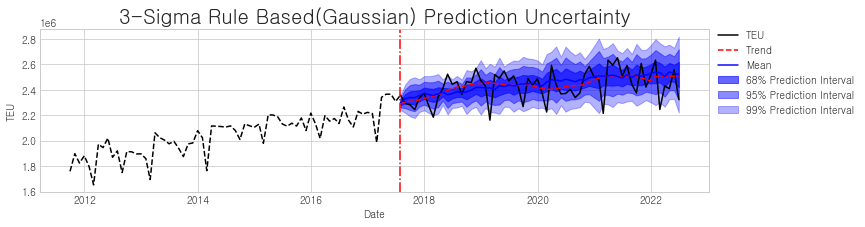

In [43]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().mean())/ test_data.reset_index()['TEU'])*100) )

In [44]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60)
UCL = df2.transpose().mean() + 2*df2.transpose().std()
LCL = df2.transpose().mean() - 2*df2.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.8166666666666667

In [53]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.95

In [54]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 126532.37
Quantile 70% Interval Sharpness 121483.87874999993


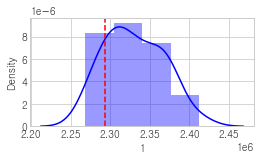

In [54]:
plt.figure(figsize=(4,2))
sns.distplot(df.transpose()[1],hist=True,color='blue') # ex. 2017.08 실제값 & 추정치 분포 비교 
plt.axvline(x=test_data.reset_index()['TEU'][1], color='red',linestyle='dashed')

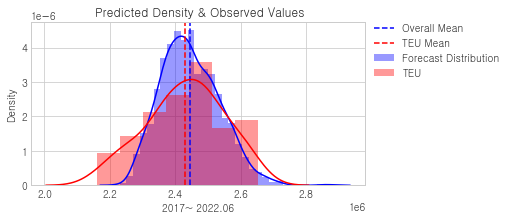

In [45]:
plt.figure(figsize=(6,3))
plt.title(' Predicted Density & Observed Values')
sns.distplot(df,color='blue',label='Forecast Distribution')
plt.axvline(x=df.transpose().mean().mean(), color='blue',linestyle='dashed',label='Overall Mean')
plt.axvline(x=test_data.mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU')
plt.xlabel('2017.07 ~ 2022.06') # 전체 예측값 & 추정치 분포 비교 
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

Median RMSE: 109749.73285256495
Median MAPE: 3.6648081175550136


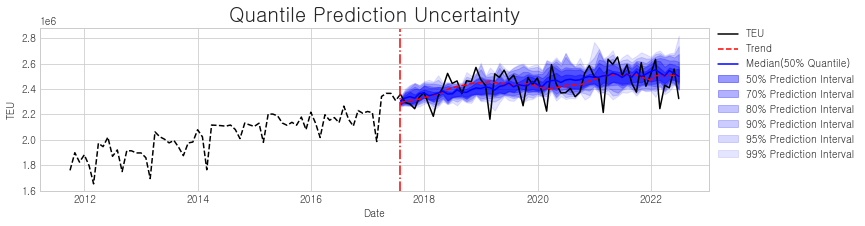

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.reset_index()['TEU'])*100) )

In [48]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.6833333333333333

In [49]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.9166666666666666

In [50]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.7666666666666667

In [51]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 253064.75
Quantile 95% Interval Sharpness 222531.3787499999
Min Max Interval Sharpness 267179.16


In [55]:
import CRPS.CRPS as pscore

In [56]:
crps = []

for i in range(0,60):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.tail(60).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

48181.78194444445
20685.437500000004
32373.232500000002
64308.411666666674
15435.881944444443
11185.83861111111
64553.55444444445
142907.63305555555
15346.723333333333
16805.302777777775
133204.66
53839.48277777778
56150.85527777778
9959.528055555556
58635.833055555566
38257.331111111125
123390.76916666667
40499.08833333333
14174.70611111111
219962.5997222222
87124.17472222222
40609.60027777777
98262.9938888889
19066.522777777776
54811.97444444445
15638.101111111113
139697.62250000003
31378.379444444443
18747.504722222224
30391.383333333328
30622.606666666667
196580.26666666666
74936.65083333332
24574.154166666664
66781.23444444446
71830.8497222222
41477.58833333333
86730.07083333335
64797.75444444446
26053.437222222223
57864.63611111111
14478.521666666666
27633.263888888887
251104.28499999995
84443.89666666667
49426.38083333334
109560.715
17394.717499999995
43506.12638888888
29546.84222222222
100512.21805555557
73103.09777777777
64650.49083333336
23033.150833333337
53399.69416666666
2

In [62]:
a = np.array([48181.78194444445,
20685.437500000004,
32373.232500000002,
64308.411666666674,
15435.881944444443,
11185.83861111111,
64553.55444444445,
142907.63305555555,
15346.723333333333,
16805.302777777775,
133204.66,
53839.48277777778,
56150.85527777778,
9959.528055555556,
58635.833055555566,
38257.331111111125,
123390.76916666667,
40499.08833333333,
14174.70611111111,
219962.5997222222,
87124.17472222222,
40609.60027777777,
98262.9938888889,
19066.522777777776,
54811.97444444445,
15638.101111111113,
139697.62250000003,
31378.379444444443,
18747.504722222224,
30391.383333333328,
30622.606666666667,
196580.26666666666,
74936.65083333332,
24574.154166666664,
66781.23444444446,
71830.8497222222,
41477.58833333333,
86730.07083333335,
64797.75444444446,
26053.437222222223,
57864.63611111111,
14478.521666666666,
27633.263888888887,
251104.28499999995,
84443.89666666667,
49426.38083333334,
109560.715,
17394.717499999995,
43506.12638888888,
29546.84222222222,
100512.21805555557,
73103.09777777777,
64650.49083333336,
23033.150833333337,
53399.69416666666,
246993.32888888888,
43685.92833333334,
92804.31833333336,
23980.15472222222,
145219.4241666667])

In [63]:
np.mean(a)

65871.87855555555

### Scenario Forecast 선정

In [41]:
mape = []

for i in range(0,30):
    a = np.mean(np.abs((test_data.reset_index()['TEU']- df[i])/ test_data.reset_index()['TEU'])*100) 
    mape.append(a)

In [42]:
pd.DataFrame(mape).sort_values(by=0).head(5)

,0
16,3.658314
4,3.736803
28,3.757946
18,3.800469
10,3.880260


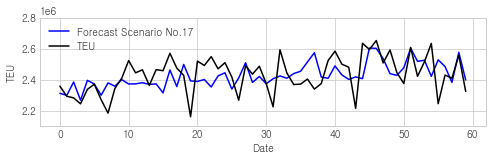

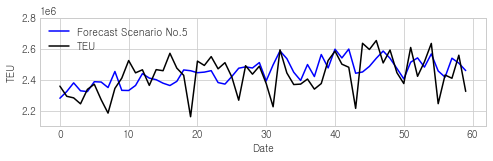

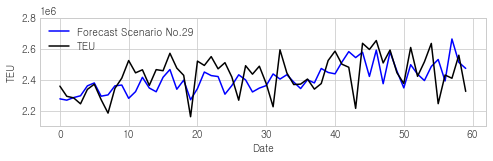

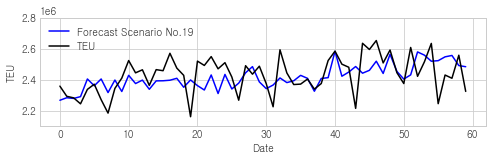

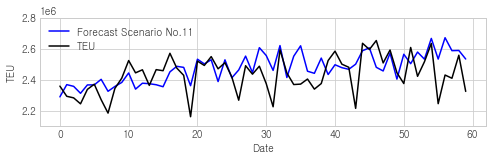

In [44]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[4],label='Forecast Scenario No.5',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[28],label='Forecast Scenario No.29',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[18],label='Forecast Scenario No.19',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[10],label='Forecast Scenario No.11',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

### Jensen Shannon Distance

In [44]:
import scipy.stats
def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

In [45]:
scenario = []

for i in range(0,30):
    a = jensen_shannon_distance(df[i],df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'])
    scenario.append(a)

In [46]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
10,0.012907
2,0.013038
23,0.013592
18,0.014135
8,0.014263


RMSE: 121055.01531141912
MAPE: 3.99858823312712
RMSE: 121235.93263514982
MAPE: 3.966568283416045
RMSE: 120459.27903240269
MAPE: 3.880259988819792
RMSE: 112413.47053435886
MAPE: 3.8004688532865503
RMSE: 117303.7630199102
MAPE: 4.124816378844016


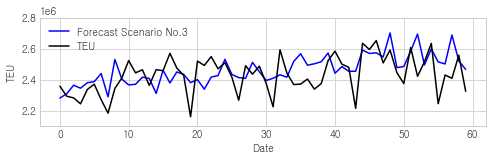

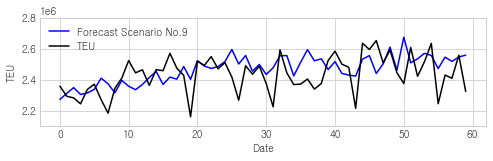

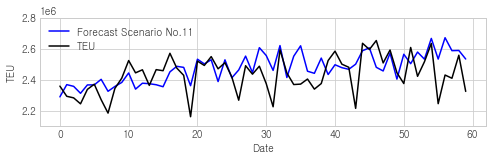

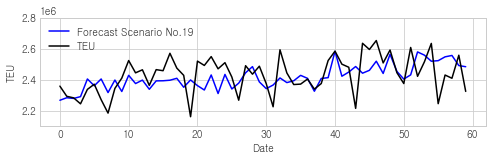

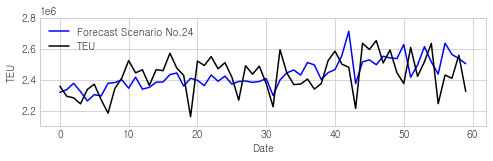

In [47]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[2],label='Forecast Scenario No.3',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[2]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[2])/ test_data.reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[8],label='Forecast Scenario No.9',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[8]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[8])/ test_data.reset_index()['TEU'])*100) )

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[10],label='Forecast Scenario No.11',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[10]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[10])/ test_data.reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[18],label='Forecast Scenario No.19',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[18]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[18])/ test_data.reset_index()['TEU'])*100) )

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[23],label='Forecast Scenario No.24',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[23]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[23])/ test_data.reset_index()['TEU'])*100) )

In [48]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
10,0.012907
2,0.013038
23,0.013592
18,0.014135
8,0.014263


In [49]:
pd.concat([df[10],df[2],df[23],df[18],df[8]],axis=1).to_csv('1번.csv')

In [50]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,11,3,24,19,9
Date,,,,,
2017-07-31,2289457.2,2281540.8,2318264.0,2267522.5,2272825.5
2017-08-31,2368074.2,2309488.0,2336010.0,2283664.8,2311367.0
2017-09-30,2357101.5,2364506.8,2376478.0,2279317.0,2348907.5
2017-10-31,2312248.0,2345125.8,2323229.2,2290791.0,2304783.0
2017-11-30,2366155.8,2380585.5,2263143.2,2404459.0,2314743.5


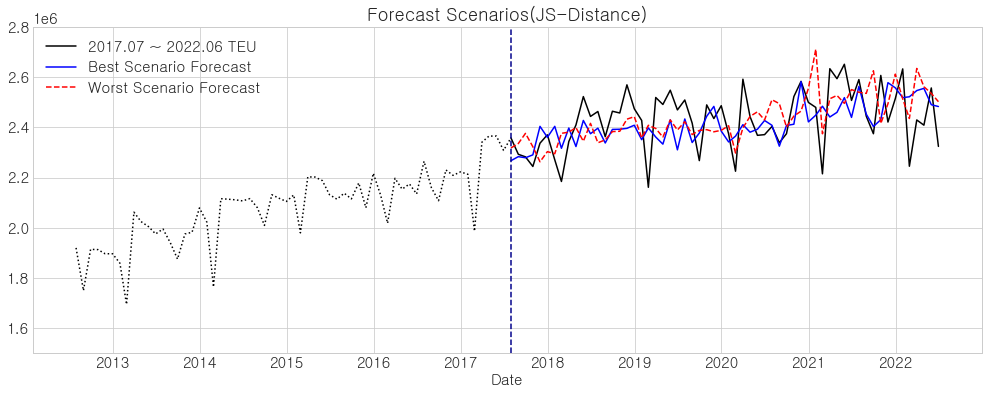

In [52]:
plt.figure(figsize=(17,6))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(JS-Distance)',fontsize=18)
plt.ylim(1.5e6,2.8e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dotted')
plt.plot(data['TEU'].iloc[210:], 'black', label='2017.07 ~ 2022.06 TEU')
plt.plot(df3['19'],color='blue',label='Best Scenario Forecast')
plt.plot(df3['24'],color='red',label='Worst Scenario Forecast',linestyle='dashed')


plt.axvline(x='2017-07-31', color='darkblue',linestyle='dashed')
plt.legend()

In [53]:
df3.head()

,11,3,24,19,9
Date,,,,,
2017-07-31,2289457.2,2281540.8,2318264.0,2267522.5,2272825.5
2017-08-31,2368074.2,2309488.0,2336010.0,2283664.8,2311367.0
2017-09-30,2357101.5,2364506.8,2376478.0,2279317.0,2348907.5
2017-10-31,2312248.0,2345125.8,2323229.2,2290791.0,2304783.0
2017-11-30,2366155.8,2380585.5,2263143.2,2404459.0,2314743.5


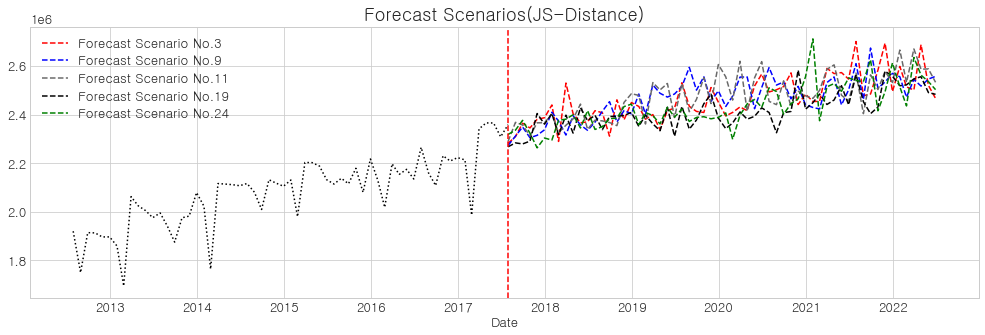

In [54]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(JS-Distance)',fontsize=18)
#plt.ylim(1.7e6,2.7e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dotted')
#plt.plot(data['TEU'].iloc[210:], 'black', label='2017.07 ~ 2022.06 TEU')
plt.plot(df3['3'],color='red',label='Forecast Scenario No.3',linestyle='dashed')
plt.plot(df3['9'],color='blue',label='Forecast Scenario No.9',linestyle='dashed')
plt.plot(df3['11'],color='dimgrey',label='Forecast Scenario No.11',linestyle='dashed')
plt.plot(df3['19'],color='black',label='Forecast Scenario No.19',linestyle='dashed')
plt.plot(df3['24'],color='green',label='Forecast Scenario No.24',linestyle='dashed')

plt.axvline(x='2017-07-31', color='red',linestyle='dashed')
plt.legend()

### Euclidean Distance

In [51]:
scenario = []

for i in range(0,30):
    a = np.linalg.norm(df[i]-df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'])
    scenario.append(a)

In [52]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
2,707026.986648
10,718848.640815
23,729336.724974
4,769262.299341
19,772617.819741


In [54]:
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[19])/ test_data.reset_index()['TEU'])*100) )

MAPE: 4.022031558638007


RMSE: 121055.01531141912
MAPE: 3.99858823312712
RMSE: 112029.94586001975
MAPE: 3.7368025255180113
RMSE: 120459.27903240269
MAPE: 3.880259988819792
RMSE: 122556.03604551505
MAPE: 4.022031558638007
RMSE: 117303.7630199102
MAPE: 4.124816378844016


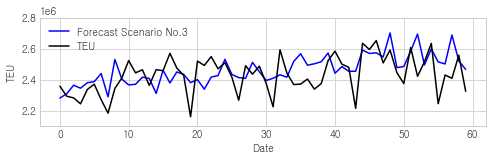

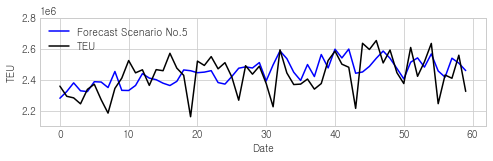

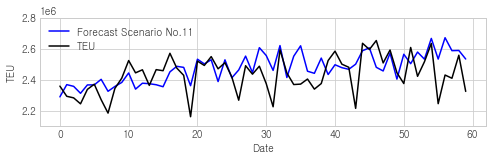

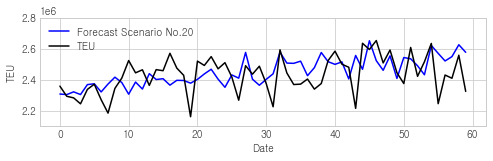

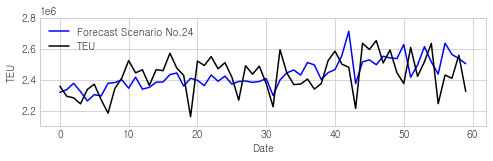

In [97]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[2],label='Forecast Scenario No.3',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[2]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[2])/ test_data.reset_index()['TEU'])*100) )

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[4],label='Forecast Scenario No.5',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[4]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[4])/ test_data.reset_index()['TEU'])*100) )

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[10],label='Forecast Scenario No.11',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[10]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[10])/ test_data.reset_index()['TEU'])*100) )

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[19],label='Forecast Scenario No.20',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[19]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[19])/ test_data.reset_index()['TEU'])*100) )

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[23],label='Forecast Scenario No.24',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[23]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[23])/ test_data.reset_index()['TEU'])*100) )

In [93]:
pd.concat([df[2],df[4],df[10],df[19],df[23]],axis=1).to_csv('1번.csv')

In [94]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,3,5,11,20,24
Date,,,,,
2017-07-31,2281540.8,2280462.2,2289457.2,2307652.8,2318264.0
2017-08-31,2309488.0,2323902.2,2368074.2,2303850.0,2336010.0
2017-09-30,2364506.8,2379464.8,2357101.5,2321617.0,2376478.0
2017-10-31,2345125.8,2328353.5,2312248.0,2304214.8,2323229.2
2017-11-30,2380585.5,2323146.5,2366155.8,2368266.2,2263143.2


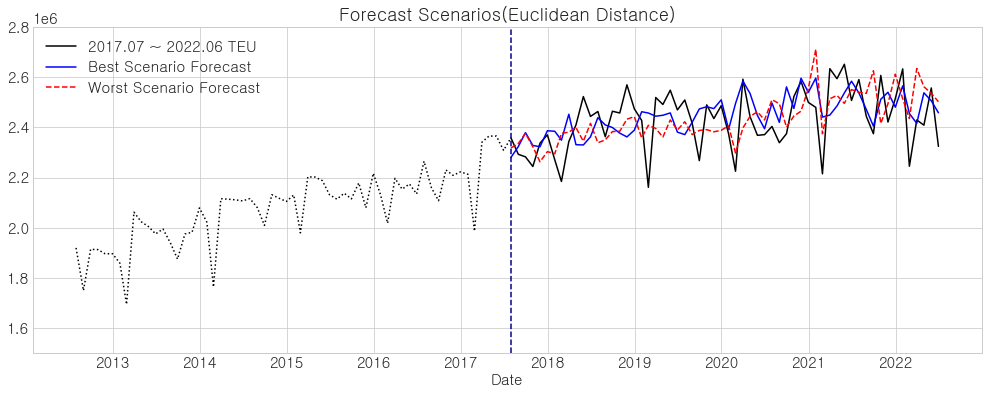

In [95]:
plt.figure(figsize=(17,6))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Euclidean Distance)',fontsize=18)
plt.ylim(1.5e6,2.8e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dotted')
plt.plot(data['TEU'].iloc[210:], 'black', label='2017.07 ~ 2022.06 TEU')
plt.plot(df3['5'],color='blue',label='Best Scenario Forecast')
plt.plot(df3['24'],color='red',label='Worst Scenario Forecast',linestyle='dashed')


plt.axvline(x='2017-07-31', color='darkblue',linestyle='dashed')
plt.legend()

In [98]:
df3.head()

,3,5,11,20,24
Date,,,,,
2017-07-31,2281540.8,2280462.2,2289457.2,2307652.8,2318264.0
2017-08-31,2309488.0,2323902.2,2368074.2,2303850.0,2336010.0
2017-09-30,2364506.8,2379464.8,2357101.5,2321617.0,2376478.0
2017-10-31,2345125.8,2328353.5,2312248.0,2304214.8,2323229.2
2017-11-30,2380585.5,2323146.5,2366155.8,2368266.2,2263143.2


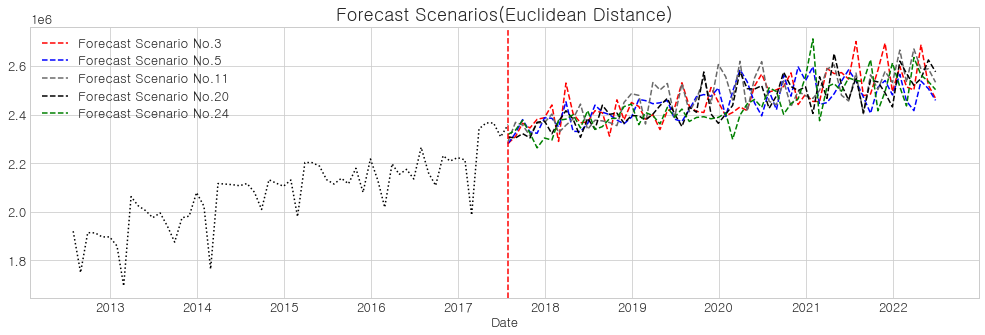

In [103]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Euclidean Distance)',fontsize=18)
#plt.ylim(1.7e6,2.7e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dotted')
#plt.plot(data['TEU'].iloc[210:], 'black', label='2017.07 ~ 2022.06 TEU')
plt.plot(df3['3'],color='red',label='Forecast Scenario No.3',linestyle='dashed')
plt.plot(df3['5'],color='blue',label='Forecast Scenario No.5',linestyle='dashed')
plt.plot(df3['11'],color='dimgrey',label='Forecast Scenario No.11',linestyle='dashed')
plt.plot(df3['20'],color='black',label='Forecast Scenario No.20',linestyle='dashed')
plt.plot(df3['24'],color='green',label='Forecast Scenario No.24',linestyle='dashed')

plt.axvline(x='2017-07-31', color='red',linestyle='dashed')
plt.legend()

### Dynamic Time Warping

In [56]:
from dtaidistance import dtw

In [57]:
scenario = []

for i in range(0,30):
    a = dtw.distance(df[i], df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'])
    scenario.append(a)

In [58]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
16,495088.490635
11,499667.379431
29,503892.761177
20,516590.597800
7,517420.088821


RMSE: 134976.6809273766
MAPE: 4.383115143833541
RMSE: 134266.7489945505
MAPE: 4.633977730527236
RMSE: 112230.4679303792
MAPE: 3.6583141244671875
RMSE: 138221.42326764073
MAPE: 4.359299755436102
RMSE: 124122.28074570086
MAPE: 4.213359211217223


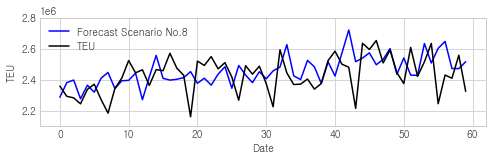

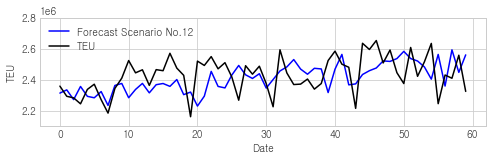

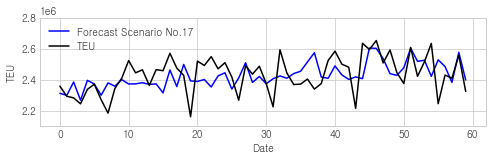

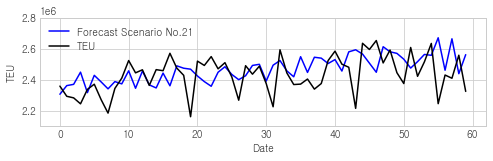

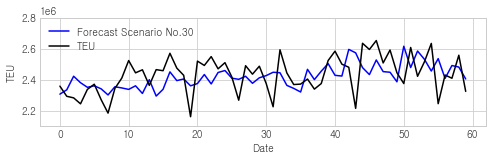

In [77]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[7],label='Forecast Scenario No.8',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[7]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[7])/ test_data.reset_index()['TEU'])*100) )

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[11],label='Forecast Scenario No.12',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[11]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[11])/ test_data.reset_index()['TEU'])*100) )

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[16]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[16])/ test_data.reset_index()['TEU'])*100) )

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[20],label='Forecast Scenario No.21',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[20]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[20])/ test_data.reset_index()['TEU'])*100) )

plt.figure(figsize=(8,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[29],label='Forecast Scenario No.30',color='blue')
plt.plot(test_data.reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df[29]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df[29])/ test_data.reset_index()['TEU'])*100) )

In [78]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
16,495088.490635
11,499667.379431
29,503892.761177
20,516590.597800
7,517420.088821


In [79]:
pd.concat([df[7],df[11],df[16],df[20],df[29]],axis=1).to_csv('1번.csv')

In [80]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,8,12,17,21,30
Date,,,,,
2017-07-31,2286689.2,2313639.8,2312329.0,2306174.0,2306825.5
2017-08-31,2380823.8,2334262.0,2298843.5,2361709.5,2334573.8
2017-09-30,2397743.2,2271691.5,2384930.0,2369917.2,2422193.8
2017-10-31,2276941.8,2356256.5,2267753.5,2448402.8,2380360.2
2017-11-30,2364192.5,2292667.2,2395749.8,2316665.8,2350849.0


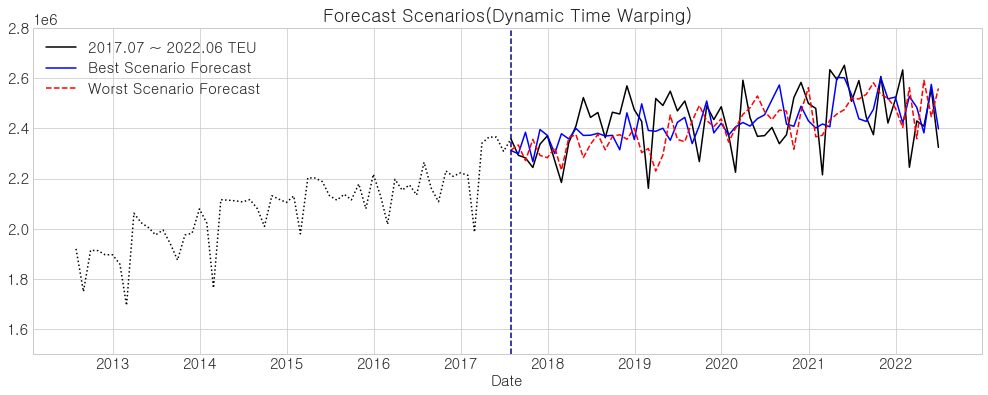

In [87]:
plt.figure(figsize=(17,6))
plt.rcParams.update({'font.size': 15})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Dynamic Time Warping)',fontsize=18)
plt.ylim(1.5e6,2.8e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dotted')
plt.plot(data['TEU'].iloc[210:], 'black', label='2017.07 ~ 2022.06 TEU')
plt.plot(df3['17'],color='blue',label='Best Scenario Forecast')
plt.plot(df3['12'],color='red',label='Worst Scenario Forecast',linestyle='dashed')


plt.axvline(x='2017-07-31', color='darkblue',linestyle='dashed')
plt.legend()

In [83]:
df3.head()

,8,12,17,21,30
Date,,,,,
2017-07-31,2286689.2,2313639.8,2312329.0,2306174.0,2306825.5
2017-08-31,2380823.8,2334262.0,2298843.5,2361709.5,2334573.8
2017-09-30,2397743.2,2271691.5,2384930.0,2369917.2,2422193.8
2017-10-31,2276941.8,2356256.5,2267753.5,2448402.8,2380360.2
2017-11-30,2364192.5,2292667.2,2395749.8,2316665.8,2350849.0


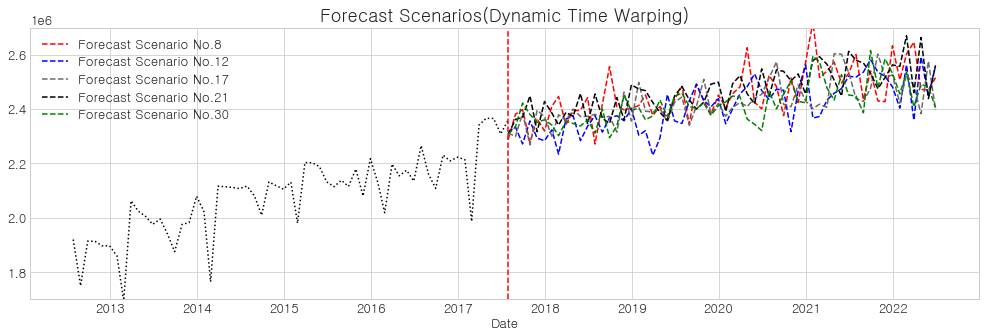

In [88]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('Date')
plt.title('Forecast Scenarios(Dynamic Time Warping)',fontsize=18)
plt.ylim(1.7e6,2.7e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dotted')
#plt.plot(data['TEU'].iloc[210:], 'black', label='2017.07 ~ 2022.06 TEU')
plt.plot(df3['8'],color='red',label='Forecast Scenario No.8',linestyle='dashed')
plt.plot(df3['12'],color='blue',label='Forecast Scenario No.12',linestyle='dashed')
plt.plot(df3['17'],color='dimgrey',label='Forecast Scenario No.17',linestyle='dashed')
plt.plot(df3['21'],color='black',label='Forecast Scenario No.21',linestyle='dashed')
plt.plot(df3['30'],color='green',label='Forecast Scenario No.30',linestyle='dashed')

plt.axvline(x='2017-07-31', color='red',linestyle='dashed')
plt.legend()

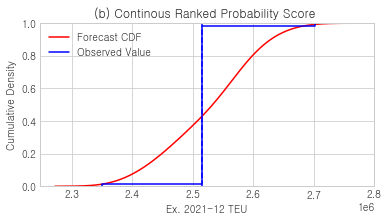

In [304]:
plt.figure(figsize=(6,3))
#sns.ecdfplot(df.transpose()[53],color='black')
sns.kdeplot(df.transpose()[53], cumulative=True,color='red',label='Forecast CDF')
sns.ecdfplot([2.35e6,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2515151,2701904],color='blue',label='Observed Value')
plt.axvline(x=2515151, color='blue',linestyle='dashed')
plt.title('(b) Continous Ranked Probability Score ')
plt.xlabel('Ex. 2021-12 TEU')
plt.ylabel('Cumulative Density')
plt.legend()
#plt.fill_between([2.35e6,2701904],0,2701904,color='blue',alpha=0.6, label='CRPS')

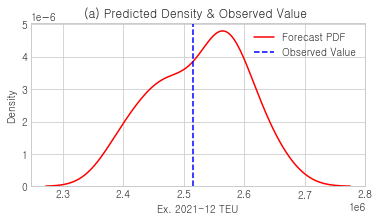

In [305]:
plt.figure(figsize=(6,3))
plt.title('(a) Predicted Density & Observed Value ')
sns.distplot(df.transpose()[53],hist=False,color='red',label='Forecast PDF')
plt.axvline(x=2515151, color='blue',linestyle='dashed',label='Observed Value')
plt.xlabel('Ex. 2021-12 TEU')
plt.legend()

### 다른 모델 대비 확률분포 추정 결과

In [62]:
attention = pd.read_csv('Attention.csv')
lstm = pd.read_csv('LSTM.csv')
tcn = pd.read_csv('TCN.csv')

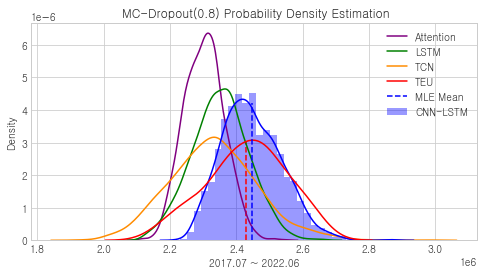

In [100]:
plt.figure(figsize=(8,4))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.mean(), ymax=0.45, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.63, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2017.07 ~ 2022.06')
plt.legend()

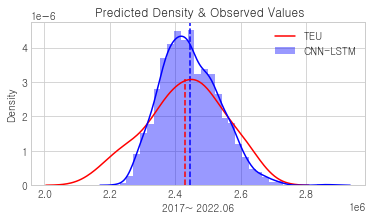

In [81]:
plt.figure(figsize=(6,3))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed')
plt.axvline(x=test_data.mean(), ymax=0.65, color='red',linestyle='dashed')
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
plt.xlabel('2017~ 2022.06')
plt.legend()

In [45]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2446229.8

### KL-Divergence(실제값 & 추정치 분포 비교)

In [47]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [48]:
for i in range(0,30):
    print(KL(df[i],test_data.reset_index()['TEU']))

1734790.869740041
2168302.8297241298
2054264.0300865124
1091638.1697738015
1261946.5382812235
432268.14091970184
2831149.898486688
1686375.6923534614
2296425.80348073
3727795.921727347
2752702.8032162166
1003015.3697298366
2918326.828103989
395542.51426990307
127472.12192210881
4093544.130903813
145234.45718527684
376599.65566651477
772005.1580234308
1323712.1031016023
2424405.233159135
1003002.9874052547
324152.1974292398
406336.11085816834
280831.83767817373
2666648.7850132696
1077752.3681185294
2810750.323478182
1229714.7634010715
472811.6460785877


In [49]:
a = np.array([1734790.869740041,
2168302.8297241298,
2054264.0300865124,
1091638.1697738015,
1261946.5382812235,
432268.14091970184,
2831149.898486688,
1686375.6923534614,
2296425.80348073,
3727795.921727347,
2752702.8032162166,
1003015.3697298366,
2918326.828103989,
395542.51426990307,
127472.12192210881,
4093544.130903813,
145234.45718527684,
376599.65566651477,
772005.1580234308,
1323712.1031016023,
2424405.233159135,
1003002.9874052547,
324152.1974292398,
406336.11085816834,
280831.83767817373,
2666648.7850132696,
1077752.3681185294,
2810750.323478182,
1229714.7634010715,
472811.6460785877])

In [50]:
np.mean(a)

1529650.6429771981

In [52]:
from scipy.stats import norm
import numpy as np

In [56]:
x.shape

(2458, 31)

### Negative Log-Likelihood(실제값 & 추정치 분포 비교)

In [63]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

In [66]:
LL = -np.sum(stats.norm.logpdf(df, loc=test_data.reset_index()['TEU'].mean(), scale=test_data.reset_index()['TEU'].std() ) )
LL

23216.680267203003

In [69]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

23362.211687575582

In [65]:
LL = -np.sum( stats.norm.logpdf(test_data.reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

824.6371475895959

In [40]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,2317808.00,2304661.00,2281540.75,2308442.25,2280462.25,2294563.25,2266646.50,2286689.25,2272825.5,2313815.25,2289457.25,2313639.75,2311252.25,2302279.50,2288623.00,2340109.00,2312329.00,2280879.75,2267522.50,2307652.75,2306174.00,2307074.25,2315464.00,2318264.00,2285360.25,2314336.50,2283466.00,2336985.25,2276552.25,2306825.50
1,2313724.00,2346578.75,2309488.00,2277632.00,2323902.25,2316264.00,2374272.00,2380823.75,2311367.0,2336819.50,2368074.25,2334262.00,2362597.25,2366483.50,2293739.50,2348338.00,2298843.50,2278275.50,2283664.75,2303850.00,2361709.50,2370625.75,2302684.75,2336010.00,2289920.25,2311931.00,2384168.25,2412363.75,2268139.75,2334573.75
2,2328220.00,2379549.25,2364506.75,2266003.75,2379464.75,2276780.50,2295991.75,2397743.25,2348907.5,2336068.25,2357101.50,2271691.50,2381555.75,2292083.25,2333816.75,2396007.75,2384930.00,2272997.50,2279317.00,2321617.00,2369917.25,2435411.25,2319202.75,2376478.00,2283824.25,2343014.00,2385493.25,2303775.75,2284692.75,2422193.75
3,2413437.25,2355769.25,2345125.75,2327185.75,2328353.50,2346123.00,2416730.50,2276941.75,2304783.0,2433555.00,2312248.00,2356256.50,2283457.25,2277394.50,2317217.75,2446860.50,2267753.50,2297556.75,2290791.00,2304214.75,2448402.75,2371091.75,2336002.75,2323229.25,2257638.50,2342018.25,2308610.75,2379508.00,2296341.50,2380360.25
4,2396704.25,2429157.75,2380585.50,2289485.75,2323146.50,2395822.75,2366218.25,2364192.50,2314743.5,2388521.25,2366155.75,2292667.25,2384362.75,2316013.50,2379940.50,2339955.75,2395749.75,2329810.50,2404459.00,2368266.25,2316665.75,2308158.25,2389226.50,2263143.25,2431857.00,2362295.50,2306284.75,2314156.50,2360221.25,2350849.00


### Bayesian Credible Interval(연습)

In [41]:
from scipy.stats import norm,bayes_mvs

In [45]:
np.array(df).reshape(-1).shape

(1800,)

In [46]:
data = [np.array(df).reshape(-1)]

In [56]:
bayes_mvs(data)

(Mean(statistic=2446280.0, minmax=(2442804.1438101083, 2449755.8561898917)),
 Variance(statistic=8037881344.0, minmax=(7597176734.610534, 8478585953.389465)),
 Std_dev(statistic=89654.2321588892, minmax=(87196.43067658755, 92112.03364119084)))

In [49]:
mean, var, std =bayes_mvs(data)

In [50]:
mean

Mean(statistic=2446280.0, minmax=(2442804.1438101083, 2449755.8561898917))

In [53]:
np.mean(data)

2446280.0

In [54]:
np.std(data)

89654.234

In [65]:
res_mean = bayes_mvs(data, alpha=0.95)
res_mean

(Mean(statistic=2446280.0, minmax=(2442138.2618927285, 2450421.7381072715)),
 Variance(statistic=8037881344.0, minmax=(7512749412.458453, 8563013275.541547)),
 Std_dev(statistic=89654.2321588892, minmax=(86725.58105733893, 92582.88326043946)))

In [79]:
np.array(res_mean)[0][0]

2446280.0

In [76]:
np.array(res_mean)[0][1][0]

2442138.2618927285

In [77]:
np.array(res_mean)[0][1][1]

2450421.7381072715

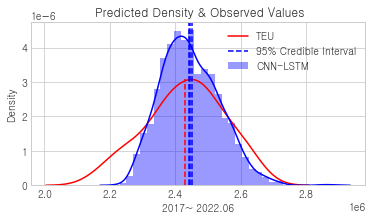

In [82]:
plt.figure(figsize=(6,3))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=test_data.mean(), ymax=0.65, color='red',linestyle='dashed')
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
plt.axvline(x=np.array(res_mean)[0][0], color='blue',linestyle='dashed')
plt.axvline(x=np.array(res_mean)[0][1][0], color='blue',linestyle='dashed',label='95% Credible Interval')
plt.axvline(x=np.array(res_mean)[0][1][1], color='blue',linestyle='dashed')
          
plt.xlabel('2017~ 2022.06')
plt.legend()